In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [4]:
import yfinance as yf
stock_symbol = 'NVDA'
df = yf.download(tickers=stock_symbol,period='1y',interval='1d')
df = df.reset_index()
df.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-04-28,153.645004,155.322495,152.154999,152.767502,152.660858,20941600
1,2021-04-29,154.000000,154.365005,150.714996,153.247498,153.140518,17319600
2,2021-04-30,151.744995,153.649994,149.970001,150.095001,149.990234,20191200
3,2021-05-03,151.250000,152.467499,147.875000,148.367493,148.263947,20391200
4,2021-05-04,146.372498,146.375000,140.102493,143.512497,143.412323,40532400


In [5]:
count = int(np.ceil(len(df) * 0.1))
signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0
signals['trend'] = df['Close']
signals['RollingMax'] = (signals.trend.shift(1).rolling(count).max())
signals['RollingMin'] = (signals.trend.shift(1).rolling(count).min())
signals.loc[signals['RollingMax'] < signals.trend, 'signal'] = -1
signals.loc[signals['RollingMin'] > signals.trend, 'signal'] = 1
signals

,signal,trend,RollingMax,RollingMin
0,0.0,152.767502,NaN,NaN
1,0.0,153.247498,NaN,NaN
2,0.0,150.095001,NaN,NaN
3,0.0,148.367493,NaN,NaN
4,0.0,143.512497,NaN,NaN
...,...,...,...,...
248,1.0,201.830002,286.559998,212.580002
249,1.0,195.149994,286.559998,201.830002
250,0.0,199.020004,286.559998,195.149994
251,1.0,187.880005,286.559998,195.149994


In [6]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
            
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [7]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, signals['signal'])

day 26: cannot sell anything, inventory 0
day 27: cannot sell anything, inventory 0
day 31: cannot sell anything, inventory 0
day 32: cannot sell anything, inventory 0
day 35: cannot sell anything, inventory 0
day 38: cannot sell anything, inventory 0
day 39: cannot sell anything, inventory 0
day 40: cannot sell anything, inventory 0
day 42: cannot sell anything, inventory 0
day 43: cannot sell anything, inventory 0
day 45: cannot sell anything, inventory 0
day 46: cannot sell anything, inventory 0
day 47: cannot sell anything, inventory 0
day 80: cannot sell anything, inventory 0
day 81: cannot sell anything, inventory 0
day 83: cannot sell anything, inventory 0
day 85: cannot sell anything, inventory 0
day 86: cannot sell anything, inventory 0
day 90: cannot sell anything, inventory 0
day 106: buy 1 units at price 206.990005, total balance 9793.009995
day 107: buy 1 units at price 205.169998, total balance 9587.839996
day 110: buy 1 units at price 197.320007, total balance 9390.51998

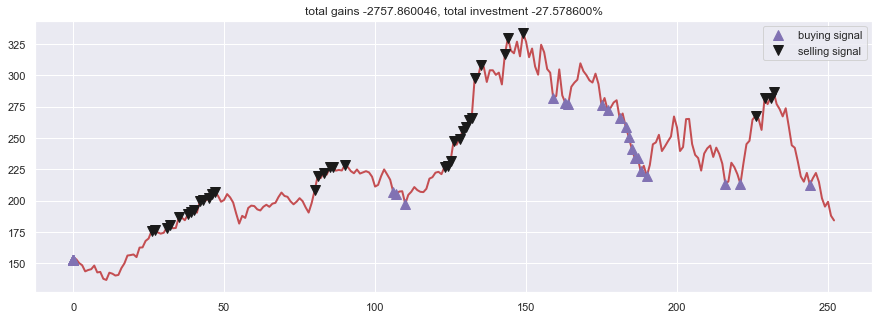

In [10]:
close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r',lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()